# Notebook Description
The purpose of this notebook is to gain some experience with multilayer and convolutional networks.

--------

# Part 1 - Fully Connected Feed Forward Networks
Training a feedforward networks in python to perform classification of 10 different species of Monkeys.<br>

The dataset consists of two files, training and validation. Each folder contains 10 subfolders labeled as n0~n9, each corresponding a species form Wikipedia's monkey cladogram. Images are 400x300 px **or larger** and JPEG format (almost 1400 images). Images were downloaded with help of the googliser open source code.

### We need to install Augmentor for image data augmentation, Augmentor is much better than Keras image augmentation function.

We will be using Augmentor class for image Augmentation. <br>

We'll be resizing every image to 150\*150\*3, to reduce the computational cost of the network, but that will affect the model very badly. <br>


In [0]:
pip install Augmentor

In [0]:
import math
import h5py
import os
import pandas as pd
import numpy as np
import cv2
import scipy
import Augmentor # <------------- you may need to install this
import random
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread 
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.framework import ops

from glob import glob
np.random.seed(1)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/ANNMonkeySpeciesClassification/'
dirpath = base_dir

# Desired Height and Width of the image because the data is large-------------------------------------------------------------------------
hght = 150
wdth = 150


# Data Augmentation, very necesarry because we are implementing Fully connected NN architecture on Image Data, instead of CNN.------------
def augmentation(df, drctry):
    for i, rows in df.iterrows():
        path = drctry+rows.label.strip()
        p = Augmentor.Pipeline(path)
        # Applying image augmentation
        p.resize(probability=1, width=wdth, height=hght)
        p.rotate(probability=1, max_left_rotation=15, max_right_rotation=15)
        p.flip_left_right(probability=0.5)
        # no of sample you want to generate
        p.process()

# After augmentation we need to replace the images back into the directory.----------------------------------------------------------------
def rename(df, drctry):
    for i, rows in df.iterrows():
        lbl = rows.label.strip()
        origin = drctry+lbl+"/output/"
        destination = drctry+lbl+"/"
        #deleting existing files
        flst = glob(os.path.join(destination, "*.jpg"))
        for f in flst:
            os.remove(f)
        for i, filename in enumerate(os.listdir(origin)):
            os.rename(origin + filename, destination + lbl + str(i).zfill(3) + ".jpg")
        os.rmdir(drctry+lbl+"/output")
        
# defining one-hot-matrix definition------------------------------------------------------------------------------------------------------
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Defining directory paths-----------------------------------------------------------------------------------------------------------------
labels_path = dirpath+r'/monkey_labels.txt'
train_dir = dirpath+'/training/'
test_dir = dirpath+'/validation/'

# Reading monkey_labels.txt using Pandas---------------------------------------------------------------------------------------------------
cols = ['label','latinName', 'commonName','training_images', 'validation_images']
labels = pd.read_csv(labels_path, names=cols, sep=',', skiprows=1)

# Applying Data Augmentation (comment once done)-------------------------------------------------------------------------------------------
#augmentation(labels, train_dir)
#augmentation(labels, test_dir)
#rename(labels, train_dir)
#rename(labels, test_dir)

# Creating training and validation data frames---------------------------------------------------------------------------------------------
clmns =  ['path']
df_train  = pd.DataFrame(columns = clmns)
for idx, row in labels.iterrows():
    path = train_dir+labels.label[idx].strip()+'/'
    df_temp = pd.DataFrame({'path': glob(os.path.join(path, '*.jpg'))})
    df_train = df_train.append(df_temp, ignore_index=True)
df_train['id'] = df_train.path.map(lambda x: x.rsplit("/",1)[1].split(".")[0])
df_train['label'] = df_train.path.map(lambda x: x.rsplit("/",1)[1].split(".")[0][:2])
#df_train.head(10)

col_names =  ['path']
df_test  = pd.DataFrame(columns = col_names)
for idx, row in labels.iterrows():
    path = test_dir+labels.label[idx].strip()+'/'
    df_temp = pd.DataFrame({'path': glob(os.path.join(path, '*.jpg'))})
    df_test = df_test.append(df_temp, ignore_index=True)
df_test['id'] = df_test.path.map(lambda x: x.rsplit("/",1)[1].split(".")[0])
df_test['label'] = df_test.path.map(lambda x: x.rsplit("/",1)[1].split(".")[0][:2])
#df_test.head(10)

# Creating training and validation data---------------------------------------------------------------------------------------------------
global train_x, test_x
train_x = np.empty((1, hght*wdth*3)) # since the size of one image, after flattening would be is height*width*3
test_x = np.empty((1, hght*wdth*3))

for idx, row in df_train.iterrows():
    image = cv2.imread(df_train.path[idx], -1)
    image_flatten = np.reshape(image, [-1])
    image_flatten = image_flatten/255.
    train_x = np.vstack((train_x, image_flatten))    
train_x = train_x[1:]
train_x = train_x.T
#print(train_x.shape)

for idx, row in df_test.iterrows():
    image = cv2.imread(df_test.path[idx], -1)
    image_flatten = np.reshape(image, [-1])
    image_flatten = image_flatten/255.
    test_x = np.vstack((test_x, image_flatten))
test_x = test_x[1:]
test_x = test_x.T
#print(test_x.shape)

# Creating training and validation labels---------------------------------------------------------------------------------------------------
global train_y, test_y

train_y_orig = np.array(df_train.label)
train_y = np.empty((int(train_x.shape[1])), dtype=np.int8)
labels = np.empty((1), dtype=np.int8)
for label in train_y_orig:
    label = label[1]
    labels = np.append(labels, int(label))
labels = labels[1:]
train_y = np.vstack((train_y, labels))
train_y = train_y[1:]
train_y = convert_to_one_hot(train_y, 10)
#print(train_y.shape)

test_y_orig = np.array(df_test.label)
test_y = np.empty((int(test_x.shape[1])), dtype=np.int8)
labels = np.empty((1), dtype=np.int8)
for label in test_y_orig:
    label = label[1]
    labels = np.append(labels, int(label,10))
labels = labels[1:]
test_y = np.vstack((test_y, labels))
test_y = test_y[1:]
test_y = convert_to_one_hot(test_y, 10)
#print(test_y.shape)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1A. Model definition
Creating a fully connected feedforward network model of 6 layers.

fc1 : [2048, hght \* wght \* 3]

fc2 : [1024, 2048] 

fc3 : [512, 1024]

fc4 : [512, 512]

fc5 : [64, 512]

fc6 : [10, 64]

In [0]:
# Model Definition ----------------------------------------------------------------------------------------------------------------------
'''
ANN architecture for the given dataset

fc1 : [2048, hght*wght*3]
fc2 : [1024, 2048] 
fc3 : [512, 1024]
fc4 : [512, 512]
fc5 : [64, 512]
fc6 : [10, 64]

'''

#----------------------------------------------------------------------------------------------------------------------------------------
def create_placeholders(n_x, n_y):
#    Creates the placeholders for the tensorflow session.    
#    Arguments:
#    n_x -- scalar, size of an image vector (num_px * num_px = 300 * 300 * 3 = 270000)
#    n_y -- scalar, number of classes (from 0 to 9, so -> 10)    
#    Returns:
#    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
#    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    
    return X, Y

#----------------------------------------------------------------------------------------------------------------------------------------
#Definition of neural nets------------------------------------------------------------------------------------------------------------
def forward_propagation(X, eps_regularization):
    
    X = tf.transpose(X)
    
    #First fully connected layer.
    fc1 = tf.contrib.layers.fully_connected(X, num_outputs=2048, activation_fn = tf.nn.leaky_relu, 
                        weights_initializer=tf.contrib.layers.xavier_initializer(), 
                        biases_initializer=tf.contrib.layers.xavier_initializer(),
                        weights_regularizer=tf.contrib.layers.l2_regularizer(eps_regularization))
    #Dropout.
    fc1 = tf.nn.dropout(fc1, rate=0.5)
    
    #Second fully connected layer.
    fc2 = tf.contrib.layers.fully_connected(fc1, num_outputs=1024, activation_fn = tf.nn.leaky_relu, 
                         weights_initializer=tf.contrib.layers.xavier_initializer(), 
                         biases_initializer=tf.contrib.layers.xavier_initializer(),
                         weights_regularizer=tf.contrib.layers.l2_regularizer(eps_regularization))
    #Dropout.
    fc2 = tf.nn.dropout(fc2, rate=0.3)
    
    #Third fully connected layer.
    fc3 = tf.contrib.layers.fully_connected(fc2, num_outputs=512, activation_fn = tf.nn.leaky_relu, 
                         weights_initializer=tf.contrib.layers.xavier_initializer(), 
                         biases_initializer=tf.contrib.layers.xavier_initializer(),
                         weights_regularizer=tf.contrib.layers.l2_regularizer(eps_regularization))
    #Dropout.
    fc3 = tf.nn.dropout(fc3, rate=0.1)
    
    #Fourth fully connected layer.
    fc4 = tf.contrib.layers.fully_connected(fc3, num_outputs=512, activation_fn = tf.nn.leaky_relu, 
                         weights_initializer=tf.contrib.layers.xavier_initializer(), 
                         biases_initializer=tf.contrib.layers.xavier_initializer(),
                         weights_regularizer=tf.contrib.layers.l2_regularizer(eps_regularization))
    
    #Fifth fully connected layer.
    fc5 = tf.contrib.layers.fully_connected(fc4, num_outputs=64, activation_fn = tf.nn.leaky_relu, 
                         weights_initializer=tf.contrib.layers.xavier_initializer(), 
                         biases_initializer=tf.contrib.layers.xavier_initializer(),
                         weights_regularizer=tf.contrib.layers.l2_regularizer(eps_regularization))
    
    #Output layer.
    output_layer = tf.contrib.layers.fully_connected(fc5, num_outputs=10)
    
    output_layer = tf.transpose(output_layer)
    
    return output_layer
  
#----------------------------------------------------------------------------------------------------------------------------------------
def compute_cost(output_layer, Y):
    """
    Computes the cost    
    Arguments:
    output_layer -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as output_layer
    Returns:
    cost - Tensor of the cost function
    """
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(output_layer)
    labels = tf.transpose(Y)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels)
    cost = tf.reduce_mean(cross_entropy)
    return cost

#----------------------------------------------------------------------------------------------------------------------------------------
def random_mini_batches(X, Y, mini_batch_size, seed):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector, of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


# 1B - Training
Training a single fully connected network for this task.

In [0]:
# Hyper-parameters---------------------------------------------------------------------------------------------------------------------
nEpochs = 1500
miniBatchSize = 16
learningRate = 0.001


# Model definition---------------------------------------------------------------------------------------------------------------------
def model(X_train, Y_train, X_test, Y_test, num_epochs = nEpochs, minibatch_size = miniBatchSize, learning_rate = learningRate, print_cost = True):
    """
    Implements a six-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    Arguments:
    X_train -- training set, of shape (input size = 67500, number of training examples = 1097)
    Y_train -- test set, of shape (output size = 10, number of training examples = 1097)
    X_test -- training set, of shape (input size = 67500, number of training examples = 272)
    Y_test -- test set, of shape (output size = 10, number of test examples = 272)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    output_layer = forward_propagation(X, eps_regularization)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(output_layer,Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(output_layer), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        


# 1B - Quantitative Evaluation
Doing some quantitative evaluation of our trained model. 

Cost after epoch 0: 2.343418
Cost after epoch 100: 0.438468
Cost after epoch 200: 0.049341
Cost after epoch 300: 0.012198
Cost after epoch 400: 0.006485
Cost after epoch 500: 0.011239
Cost after epoch 600: 0.003074
Cost after epoch 700: 0.007427
Cost after epoch 800: 0.002654
Cost after epoch 900: 0.000820
Cost after epoch 1000: 0.004080
Cost after epoch 1100: 0.000856
Cost after epoch 1200: 0.000522
Cost after epoch 1300: 0.000987
Cost after epoch 1400: 0.003500


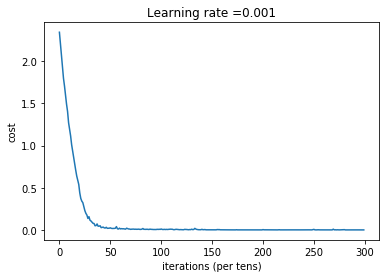

Train Accuracy: 0.9990884
Test Accuracy: 0.44852942


In [0]:
# Training starts here------------------------------------------------------------------------------------------------------------------

model(train_x, train_y, test_x, test_y)

In the first part we've implemented a fully connected NN architecture of shape. <br>
67500 (image dimension 150\*150\*3) | 2048 (layer-1) | 1024 (layer-2) | 512 (layer-3) | 512 (layer-4) | 256 (layer-5) | 64 (layer-6) | 10 (softmax-layer).<br>

#### We can see that It over-fitted very badly. We got 45-50% accuracy using the above method. The model is overfitting, because the dev accuracy is 99.9% and validation accuracy is 45-50% <br>





---------------------------------------------

# Part 2 - CNN Architecture
In part 2 we'll be training an advanced architecture such as CNN to perform the same task from part 1.


# 2A - Preprocessing


In [0]:
import math                      # providing access to the mathematical functions defined by the C standard
import matplotlib.pyplot as plt  # plotting library
import scipy                     # scientific computnig and technical computing
import cv2                       # working with, mainly resizing, images
import numpy as np               # dealing with arrays
import glob                      # return a possibly-empty list of path names that match pathname
import os                        # dealing with directories
import pandas as pd              # providing data structures and data analysis tools
import tensorflow as tf       
import itertools
import random
from random import shuffle       # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm            # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/CNNMonkeySpeciesClassification/'
dirpath = base_dir

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Defining directory paths-----------------------------------------------------------------------------------------------------------------
labels_path = dirpath+r'/monkey_labels.txt'
train_dir = dirpath+'/training/'
test_dir = dirpath+'/validation/'

# Reading monkey_labels.txt using Pandas---------------------------------------------------------------------------------------------------
cols = ['label','latinName', 'commonName','training_images', 'validation_images']
labels = pd.read_csv(labels_path, names=cols, sep=',', skiprows=1)


# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples 

Mounted at /content/gdrive
Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


# 2B - Model definition
The CNN model consists of 4 Conv layers followed by 2 dense fully-connected layers. I've printed the configuration below.

In [0]:

# Model Definition----------------------------------------------------------------------------------------------------------------------------------------------
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 36, 64)        18496     
__________

# 2C - Training

In [0]:
LR = 1e-3
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20

filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
17/17 [==============================] - 200s 12s/step - loss: 2.3149 - acc: 0.1167 - val_loss: 2.2480 - val_acc: 0.1992

Epoch 00001: val_acc improved from -inf to 0.19922, saving model to /content/model.h5f
Epoch 2/200
17/17 [==============================] - 32s 2s/step - loss: 2.1418 - acc: 0.2070 - val_loss: 2.0271 - val_acc: 0.2656

Epoch 00002: val_acc improved from 0.19922 to 0.26562, saving model to /content/model.h5f
Epoch 3/200
17/17 [==============================] - 35s 2s/step - loss: 1.9541 - acc: 0.2914 - val_loss: 1.7930 - val_acc: 0.4030

Epoch 00003: val_acc improved from 0.26562 to 0.40299, saving model to /content/model.h5f
Epoch 4/200
17/17 [==============================] - 31s 2s/step - loss: 1.8209 - acc: 0.3494 - val_loss: 1.8296 - val_acc: 0.3125

Epoch 00004: val_acc did not improve from 0.40299
Epoch 5/200
17/17 [==============================] - 32s 2s/step - loss: 1.7991 - acc: 0.3346 - val_loss:

# 2D - Quantitative Evaluation


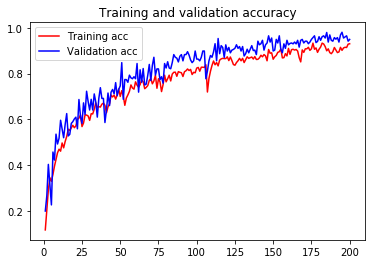

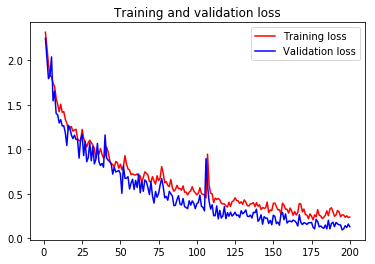

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

# Conclusion
We can clearly see the difference, CNN architecture achieved 98% accuracy as compared to Fully Connected Feed Forward NN architecture which was able to achieve accuracy only up to 45%. <br>

This shows us the importance of different NN architectures for different problems.